In [2]:
import os
import numpy as np
import pandas as pd
import csv
import tqdm
import pickle
from vgg import get_cls,get_img_paths,svm_classify
from vgg import face_verification,is_match,generate_embeddings
from sklearn.metrics import DetCurveDisplay,det_curve
from sklearn.metrics import RocCurveDisplay,roc_curve
import matplotlib.pyplot as plt



label_path = './test_list.txt'
r_idx_path = 'identity_meta.csv'

# build class to name mapping
mapping = dict()
with open('identity_meta.csv','r',encoding='utf-8') as f:
    csvFile = csv.reader(f)
    for line in csvFile:
        mapping[line[0]]=line[1]


In [5]:
def face_identification_eval():
    cls = get_cls()
    train_image_paths,test_image_paths,train_labels,test_gt_labels = get_img_paths(cls)
    if not os.path.exists('feats.pkl'):
        train_feats = generate_embeddings(train_image_paths)
        test_image_feats = generate_embeddings(test_image_paths)
        with open('feats.pkl','wb') as f:
            pickle.dump((train_feats,test_image_feats),f)
    else:
        with open('feats.pkl','rb') as f:
            train_feats,test_image_feats = pickle.load(f)
    train_feats = np.squeeze(train_feats)
    test_image_feats = np.squeeze(test_image_feats)
    print(train_feats.shape)
    print(test_image_feats.shape)
    test_pred_labels, test_pred_conf = svm_classify(train_feats,train_labels,test_image_feats)
    return test_gt_labels, test_pred_labels, test_pred_conf

# identification eval
test_gt , test_pred, pred_conf = face_identification_eval()


(600, 2048)
(200, 2048)


C:\Users\feasi\AppData\Local\Temp\ipykernel_4564\2255021137.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]


0.015

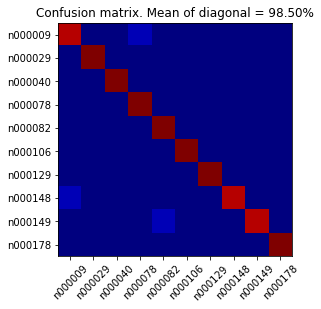

In [4]:
tp = 0
fp = 0
for i,l in enumerate(test_gt):
    if test_pred[i]==test_gt[i]:
        tp+=1
    else:
        fp+=1
top_1_err = fp/len(test_gt)
# top_1_err


def show_results(train_image_paths, test_image_paths, train_labels, test_labels,
                 categories, abbr_categories, predicted_categories):
    """
    shows the results
    :param train_image_paths:
    :param test_image_paths:
    :param train_labels:
    :param test_labels:
    :param categories:
    :param abbr_categories:
    :param predicted_categories:
    :return:
    """
    from sklearn.metrics import confusion_matrix
    cat2idx = {cat: idx for idx, cat in enumerate(categories)}

    # confusion matrix
    y_true = [cat2idx[cat] for cat in test_labels]
    y_pred = [cat2idx[cat] for cat in predicted_categories]
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]
    acc = np.mean(np.diag(cm))
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('jet'))
    plt.title('Confusion matrix. Mean of diagonal = {:4.2f}%'.format(acc*100))
    tick_marks = np.arange(len(categories))
    plt.tight_layout()
    plt.xticks(tick_marks, abbr_categories, rotation=45)
    plt.yticks(tick_marks, categories)
show_results(None,None,None, test_labels=test_gt,categories=get_cls(),abbr_categories=get_cls(),predicted_categories=test_pred)
top_1_err

In [3]:
def get_cls_veri():
    cls =[]
    for root,dirs,files in os.walk('./veri_test'):
        for d in dirs:
            cls.append(d)
    return cls

def face_identification_eval():
    cls = get_cls_veri()
    train_image_paths,test_image_paths,train_labels,test_gt_labels = get_img_paths(cls)

    image_paths,labels = get_img_paths(cls,type='veri_test')
    with open('feats.pkl','rb') as f:
        train_feats,test_image_feats = pickle.load(f)


    y_true=[]
    y_sim=[]
    embeddings = generate_embeddings(image_paths)
    
    embeddings = np.concatenate((embeddings,train_feats))
    labels = np.concatenate((labels,train_labels))
    for i,p in enumerate(embeddings):
        for j in range(i,len(embeddings)):
            match,sim_score=is_match(embeddings[i],embeddings[j])
            if labels[i]==labels[j]:
                y_true.append(1)
            else:
                y_true.append(0)
            y_sim.append(sim_score)
    return y_true,y_sim
    
y_true,y_sim=face_identification_eval()
y_sim
    
   
    

veri_test\ajw\ajw_1.jpg
1/1 [==============================] - 0s 66ms/step
veri_test\ajw\ajw_2.jpg
1/1 [==============================] - 0s 70ms/step
veri_test\ajw\ajw_3.jpg
1/1 [==============================] - 0s 72ms/step
veri_test\hhh\hhh3.jpg
1/1 [==============================] - 0s 71ms/step
veri_test\hhh\hhh_1.jpg
1/1 [==============================] - 0s 72ms/step
veri_test\hhh\hhh_2.jpg
1/1 [==============================] - 0s 66ms/step
veri_test\lzj\lzj_1.jpg
1/1 [==============================] - 0s 76ms/step
veri_test\lzj\lzj_2.jpg
1/1 [==============================] - 0s 73ms/step
veri_test\n000009\0001_01.jpg
1/1 [==============================] - 0s 69ms/step
veri_test\n000009\0003_01.jpg
1/1 [==============================] - 0s 76ms/step
veri_test\n000009\0004_01.jpg
1/1 [==============================] - 0s 67ms/step
veri_test\n000009\0005_01.jpg
1/1 [==============================] - 0s 66ms/step
veri_test\n000009\0006_01.jpg
1/1 [==============================

[1,
 0.7690954804420471,
 0.7700475454330444,
 0.43151652812957764,
 0.4659307599067688,
 0.43677234649658203,
 0.5126335620880127,
 0.49199074506759644,
 0.3645143508911133,
 0.312463641166687,
 0.27989619970321655,
 0.26027563214302063,
 0.3011258840560913,
 0.19216731190681458,
 0.2343369871377945,
 0.21186470985412598,
 0.19551777839660645,
 0.15234914422035217,
 0.14590762555599213,
 0.17021211981773376,
 0.12465561181306839,
 0.14237895607948303,
 0.16944314539432526,
 0.16871081292629242,
 0.1966938078403473,
 0.17683768272399902,
 0.1709522306919098,
 0.1729046255350113,
 0.17391729354858398,
 0.15601590275764465,
 0.18611565232276917,
 0.1856829673051834,
 0.1847631335258484,
 0.1835661679506302,
 0.18272452056407928,
 0.1949099451303482,
 0.20818109810352325,
 0.1817571520805359,
 0.15802495181560516,
 0.2082325667142868,
 0.1798536479473114,
 0.18584871292114258,
 0.21493206918239594,
 0.21367153525352478,
 0.19094648957252502,
 0.2061036378145218,
 0.19850040972232819,
 0.1

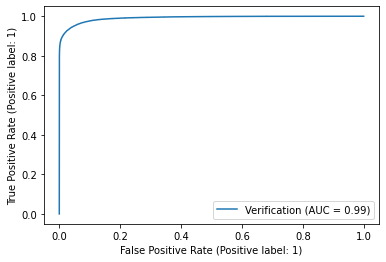

In [11]:
RocCurveDisplay.from_predictions(y_true,y_sim, name='Verification')